In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [65]:
# Load the CSV file
df = pd.read_csv("/Users/philiplacava/Projects/ECON-550/550_project_data.csv")
df.head()
# Creating date variable for plotting 
df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

# u = unionion membership, w = wage rate, jo = job openings. 
# total_ui_claims = total unemployment insurance claims
# each log corresponds to heach level variable

In [66]:
# Mapping groups based on PA state essential worker definitions
group_mapping = {
    1: None,  # 'Total Private' is not classified
    2: 'Not-Essential',  # 'Accommodations and food services'
    3: None,  # 'Arts and entertainment'
    4: 'Mixed',  # 'Construction'
    5: 'Mixed',  # 'Durable Goods Manufacturing'
    6: 'Mixed',  # 'Education (Private Sector)'
    7: 'Mixed',  # 'Financial Activities'
    8: 'Essential',  # 'Healthcare'
    9: 'Essential',  # 'Information'
    10: 'Not-Essential',  # 'Leisure and Hospitality'
    11: 'Essential',  # 'Mining and Logging'
    12: 'Mixed',  # 'Non Durable Goods Manufacturing'
    13: 'Mixed',  # 'Other Services' is not classified
    14: 'Mixed',  # 'Professional & Business Services'
    15: 'Not-Essential',  # 'Real Estate'
    16: 'Mixed',  # 'Retail Trade'
    17: 'Essential',  # 'Warehousing, Transportation and Utilities'
    18: 'Essential',  # 'Transportation'
    19: 'Essential',  # 'Wholesale Trade'
}
# Map the original industry labels to the group labels
df['group'] = df['industry'].map(group_mapping)
group_df = df[df['group'].notna()]

In [67]:
# Mapping labels to industry
industry_labels = {
    1: 'Total Private',
    2: 'Accommodations and food services',
    3: 'Arts and entertainment',
    4: 'Construction',
    5: 'Durable Goods Manufacturing',
    6: 'Education (Private Sector)',
    7: 'Financial Activities',
    8: 'Healthcare',
    9: 'Information',
    10: 'Leisure and Hospitality',
    11: 'Mining and Logging',
    12: 'Non Durable Goods Manufacturing',
    13: 'Other Services',
    14: 'Professional & Business Services',
    15: 'Real Estate',
    16: 'Retail Trade',
    17: 'Warehousing, Transportation and Utilities',
    18: 'Transportation',
    19: 'Wholesale Trade',
}
df['industry'] = df['industry'].map(industry_labels) 

In [68]:
# Mapping colors to industry
color_mapping = {
    'Total Private': '#000000',  # Black
    'Accommodations and food services': '#FFC0CB',  # Light pink
    'Arts and entertainment': '#FF1493',  # Deep pink
    'Construction': '#A52A2A',  # Brown
    'Durable Goods Manufacturing': '#ff8c00',  # Dark Orange
    'Education (Private Sector)': '#1e90ff',  # Dodger Blue
    'Financial Activities': '#2e8b57',  # Sea Green
    'Healthcare': '#87ceeb',  # Sky Blue
    'Information': '#0000ff',  # Blue
    'Leisure and Hospitality': '#FF69B4',  # Medium pink
    'Mining and Logging': '#ff6347',  # Tomato
    'Non Durable Goods Manufacturing': '#ffa500',  # Orange
    'Other Services': '#808080',  # Grey
    'Professional & Business Services': '#32cd32',  # Lime Green
    'Real Estate': '#3cb371',  # Medium Sea Green
    'Retail Trade': '#9932cc',  # Dark Orchid
    'Warehousing, Transportation and Utilities': '#7851A9',  # Royal Purple
    'Transportation': '#4B0082',  # Indigo
    'Wholesale Trade': '#800080',  # Purple
}


In [69]:
# Creating seperated dataframes for the purposes of plotting
# 'filtered_df' will exclude rows where 'industry' is 'Total Private'
filtered_df = df[df['industry'] != 'Total Private']
# Get unique industries from the filtered DataFrame
unique_industries = filtered_df['industry'].unique()

# Grouping industries with similar levels of job openings together
ind1 = [
    'Accommodations and food services',
    'Leisure and Hospitality',
    'Retail Trade',
    'Education (Private Sector)',
    'Healthcare',
    'Professional & Business Services',
    'Warehousing, Transportation and Utilities'
]

# Create 'filtered_df1' from 'filtered_df' including the listed industries
filtered_df1 = filtered_df[filtered_df['industry'].isin(ind1)]


# Print the unique industries
print(unique_industries)

ind2 = [
    'Mining and Logging',
    'Construction',
    'Durable Goods Manufacturing',
    'Non Durable Goods Manufacturing',
    'Wholesale Trade',
    'Transportation'
]

# Create the first filtered dataframe
filtered_df2 = filtered_df[filtered_df['industry'].isin(ind2)]

ind3 = [
    'Information',
    'Financial Activities',
    'Real Estate',
    'Arts and entertainment',
    'Other Services'
]

# Create the second filtered dataframe
filtered_df3 = filtered_df[filtered_df['industry'].isin(ind3)]

['Accommodations and food services' 'Arts and entertainment'
 'Construction' 'Durable Goods Manufacturing' 'Education (Private Sector)'
 'Financial Activities' 'Healthcare' 'Information'
 'Leisure and Hospitality' 'Mining and Logging'
 'Non Durable Goods Manufacturing' 'Other Services'
 'Professional & Business Services' 'Real Estate' 'Retail Trade'
 'Warehousing, Transportation and Utilities' 'Transportation'
 'Wholesale Trade']


In [70]:
## Collecting significant coeficients, p values and model summaries for printing

significant_coefficients = {}
significant_pvalues = {}
model_summaries = {}


# looping the regression by industry
for industry in df['industry'].unique():
    df_industry = df[df['industry'] == industry].copy()
    formula = ('jo_log ~ C(covid) * inflation_fe_log + '
               'C(covid) * unemployment_log + '
               'C(covid) * u_log + '
               'C(covid) * w_log')
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')
    
    # Store data from each regression 
    model_summaries[industry] = model.summary()
    significant_coefs = model.params[model.pvalues < 0.05]
    significant_pvalues_industry = model.pvalues[model.pvalues < 0.05]
    # pass over non-significant values when applicable
    if not significant_coefs.empty:
        significant_coefficients[industry] = significant_coefs
        significant_pvalues[industry] = significant_pvalues_industry

In [71]:
# Printing significant coeficients
for industry in significant_coefficients:
    print(f"{industry}:")
    for variable, coef in significant_coefficients[industry].items():
        pvalue = significant_pvalues[industry][variable]
        print(f"{variable}, {coef:.4f}, {pvalue:.4f}")
    print()  


Total Private:
inflation_fe_log, -2.7315, 0.0106
C(covid)[T.1]:inflation_fe_log, -4.3026, 0.0310
unemployment_log, -0.9287, 0.0000
C(covid)[T.1]:unemployment_log, 0.4351, 0.0103

Accommodations and food services:
C(covid)[T.1]:inflation_fe_log, -14.3891, 0.0000
unemployment_log, -1.0780, 0.0000
C(covid)[T.1]:unemployment_log, 0.6125, 0.0277
u_log, -1.4207, 0.0064
C(covid)[T.1]:u_log, 3.8031, 0.0018
w_log, -1.1540, 0.0038
C(covid)[T.1]:w_log, 7.4219, 0.0000

Arts and entertainment:
C(covid)[T.1], 36.4451, 0.0428
inflation_fe_log, 8.4372, 0.0080
C(covid)[T.1]:inflation_fe_log, -10.2879, 0.0146

Construction:
Intercept, -78.8714, 0.0000
C(covid)[T.1], 81.4828, 0.0000
inflation_fe_log, 12.2834, 0.0000
C(covid)[T.1]:inflation_fe_log, -12.3726, 0.0011
unemployment_log, 0.9371, 0.0028
C(covid)[T.1]:unemployment_log, -1.2073, 0.0002

Durable Goods Manufacturing:
inflation_fe_log, 6.8030, 0.0001
C(covid)[T.1]:inflation_fe_log, -10.5632, 0.0015
C(covid)[T.1]:u_log, 7.7133, 0.0292

Education (Pri

In [72]:
# Initialize dictionaries to store the results over time
significant_coefficients_grouped = {}
significant_pvalues_grouped = {}
results_summaries = {}
results = {}
# Loop through each group
for group in group_df['group'].unique():
    # Loop through each year
    for year in group_df['year'].unique():
        # Subset the DataFrame for the current group and year
        group_year_data = group_df[(group_df['group'] == group) & (group_df['year'] == year)]

        # Check if the subset is empty; if so, skip to the next iteration
        if group_year_data.empty:
            continue

        # Run the regression
        result = smf.ols(formula='jo_log ~ inflation_fe_log + unemployment_log + u_log + w_log', data=group_year_data).fit(cov_type='HC1')
        significant_coefs = result.params[result.pvalues < 0.05]
        significant_pvalues = result.pvalues[result.pvalues < 0.05]

        # Store significant coefficients and p-values if any
        if not significant_coefs.empty:
            significant_coefficients_grouped[(group, year)] = significant_coefs
            significant_pvalues_grouped[(group, year)] = significant_pvalues

        # Store the result summary for later printing
        results_summaries[(group, year)] = result.summary()
        # Store results for plotting over time
        results[(group, year)] = result

In [73]:
#Printing significant coeficients
for industry in significant_coefficients_grouped:
    print(f"{industry}:")
    for variable, coef in significant_coefficients_grouped[industry].items():
        pvalue = significant_pvalues_grouped[industry][variable]
        print(f"{variable}, {coef:.4f}, {pvalue:.4f}")
    print()  

('Not-Essential', 2013):
u_log, 1.0602, 0.0000
w_log, -0.8318, 0.0184

('Not-Essential', 2014):
u_log, 1.0308, 0.0000
w_log, -1.1739, 0.0000

('Not-Essential', 2015):
u_log, 0.9841, 0.0000
w_log, -1.0570, 0.0000

('Not-Essential', 2016):
u_log, 1.0456, 0.0000
w_log, -0.9513, 0.0000

('Not-Essential', 2017):
u_log, 0.9904, 0.0000
w_log, -1.1539, 0.0001

('Not-Essential', 2018):
u_log, 1.0130, 0.0000
w_log, -1.4247, 0.0000

('Not-Essential', 2019):
unemployment_log, 1.1099, 0.0220
u_log, 1.0026, 0.0000
w_log, -1.0737, 0.0000

('Not-Essential', 2020):
unemployment_log, -0.2722, 0.0016
u_log, 0.9763, 0.0005

('Not-Essential', 2021):
Intercept, -177.5087, 0.0000
inflation_fe_log, 28.6661, 0.0000
unemployment_log, 1.6172, 0.0062
u_log, 1.2461, 0.0000
w_log, -0.9373, 0.0135

('Not-Essential', 2022):
Intercept, -25.1448, 0.0388
inflation_fe_log, 4.0169, 0.0052
u_log, 0.9890, 0.0000
w_log, -1.3325, 0.0004

('Not-Essential', 2023):
u_log, 0.9375, 0.0000
w_log, -1.3576, 0.0000

('Mixed', 2013):
u

In [74]:
# Convert regression results to a DataFrame for easier plotting
plot_data = []
for (group, year), result in results.items():
    coefs = result.params
    pvalues = result.pvalues
    for var in coefs.index:
        coef = coefs[var]
        pvalue = pvalues[var]
        plot_data.append({
            'group': group, 
            'year': year, 
            'variable': var, 
            'coefficient': coef,
            'pvalue': pvalue
        })
# We have a data frame
coefficients_df = pd.DataFrame(plot_data)


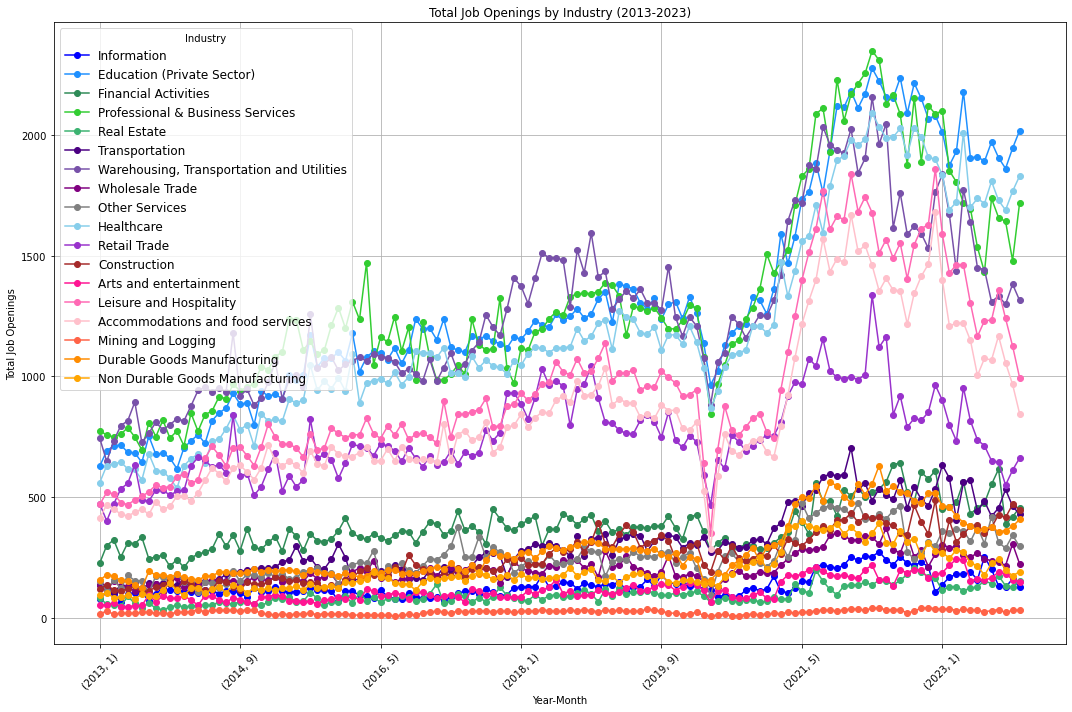

In [75]:
# Plotting job openings over time across industries minus total private 
grouped_df1 = filtered_df.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()

# Create the pivot table
pivot_df1 = grouped_df1.pivot_table(index=['year', 'month'], columns='industry', values='jo')

# Ensure the columns are ordered consistently with the color mapping
ordered_columns1 = sorted(pivot_df1.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df1 = pivot_df1[ordered_columns1]

# Plotting with color mapping
pivot_df1.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


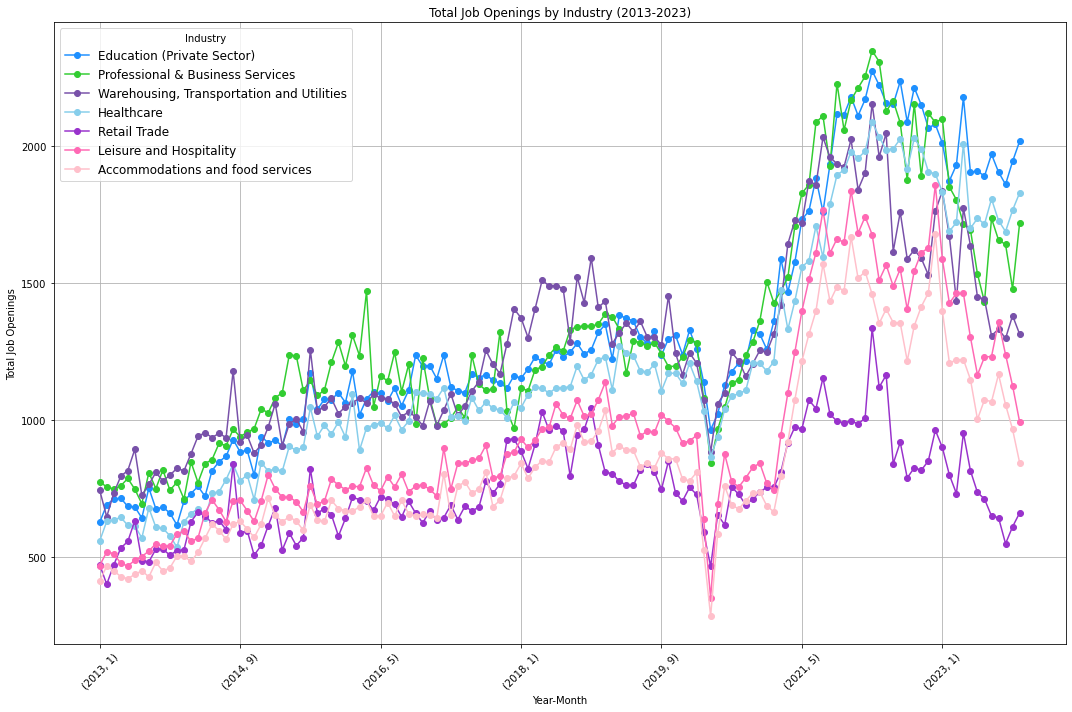

In [76]:
# Plotting group 1
grouped_df4 = filtered_df1.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df4 = grouped_df4.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns4 = sorted(pivot_df4.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df4 = pivot_df4[ordered_columns4]

pivot_df4.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

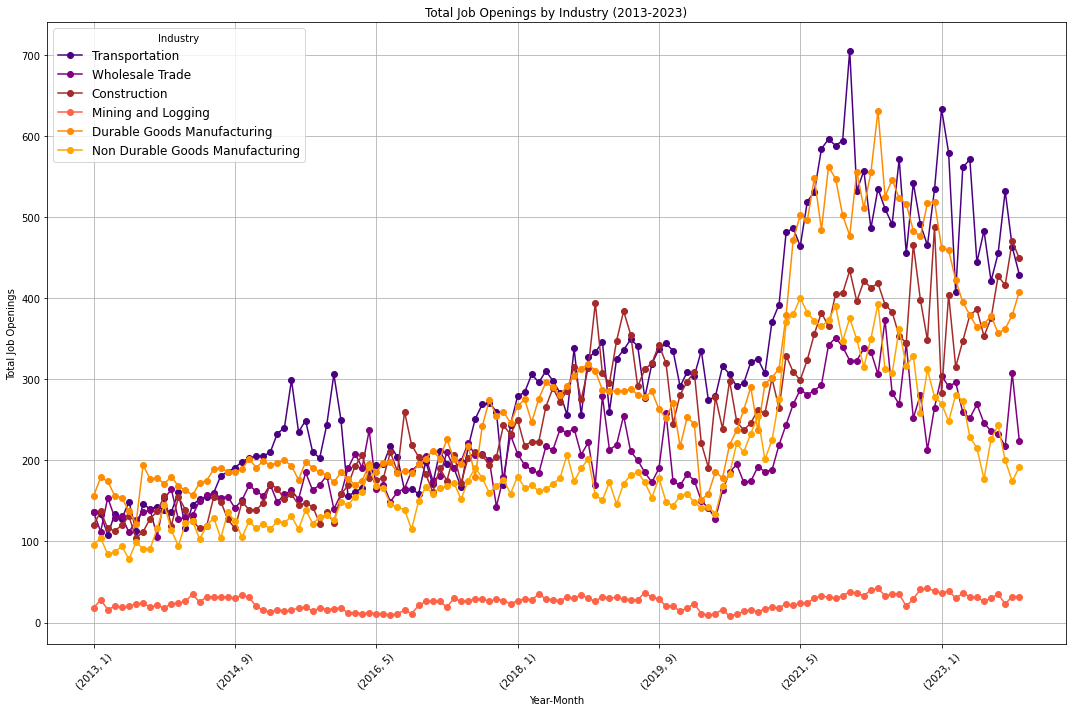

In [77]:
# Plotting group 2
grouped_df5 = filtered_df2.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df5 = grouped_df5.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns5 = sorted(pivot_df5.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df5 = pivot_df5[ordered_columns5]

pivot_df5.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

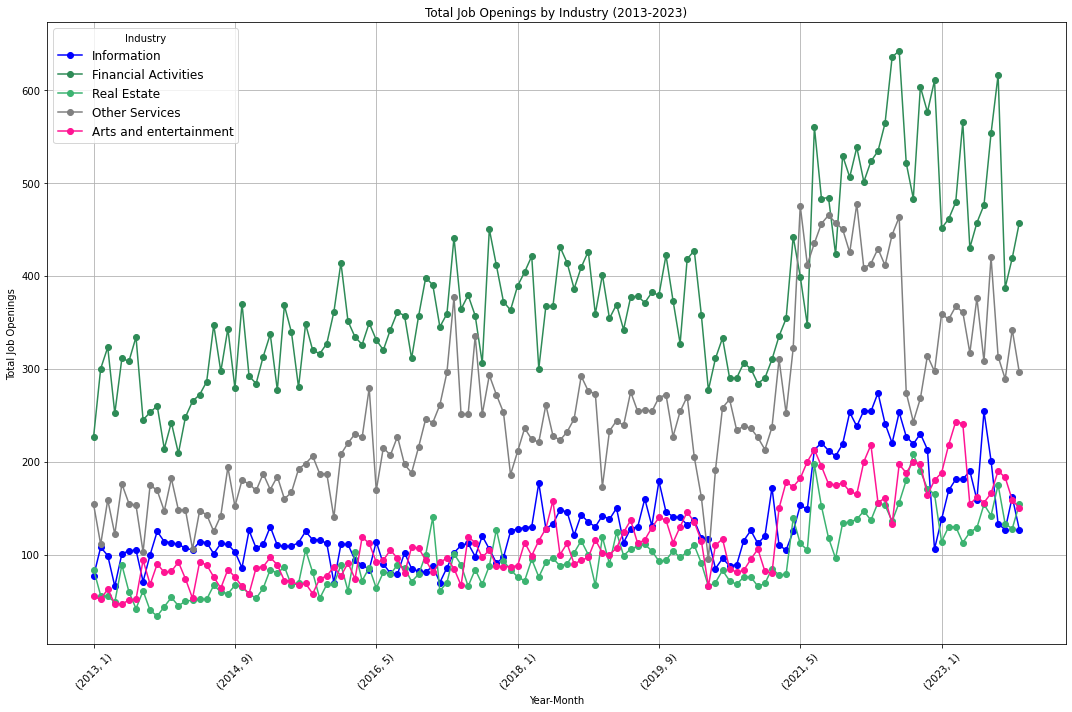

In [78]:
# Plotting group 3
grouped_df6 = filtered_df3.groupby(['industry', 'year', 'month'])['jo'].mean().reset_index()
# Recreate the pivot table
pivot_df6 = grouped_df6.pivot_table(index=['year', 'month'], columns='industry', values='jo')

ordered_columns6 = sorted(pivot_df6.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df6 = pivot_df6[ordered_columns6]

pivot_df6.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Total Job Openings by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Total Job Openings')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

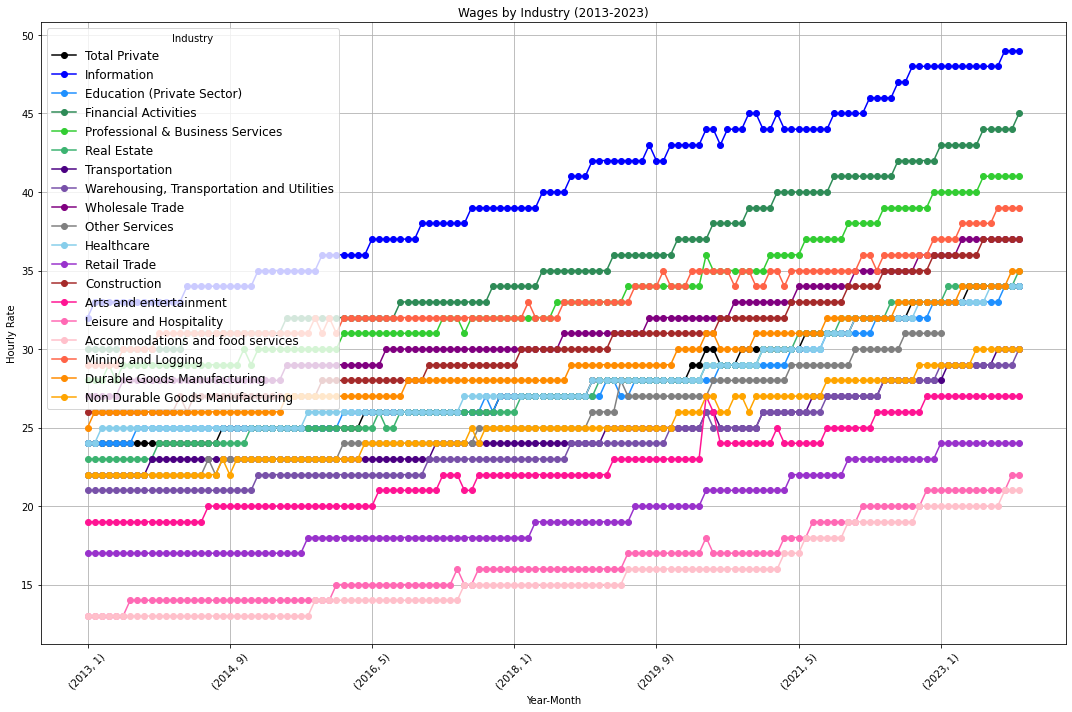

In [79]:
# Plotting wages across industries over time 
grouped_df2 = df.groupby(['industry', 'year', 'month'])['w'].mean().reset_index()

# Recreate the pivot table
pivot_df2 = grouped_df2.pivot_table(index=['year', 'month'], columns='industry', values='w')

ordered_columns2 = sorted(pivot_df2.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df2 = pivot_df2[ordered_columns2]

pivot_df2.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Wages by Industry (2013-2023)')
plt.xlabel('Year-Month')
plt.ylabel('Hourly Rate')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


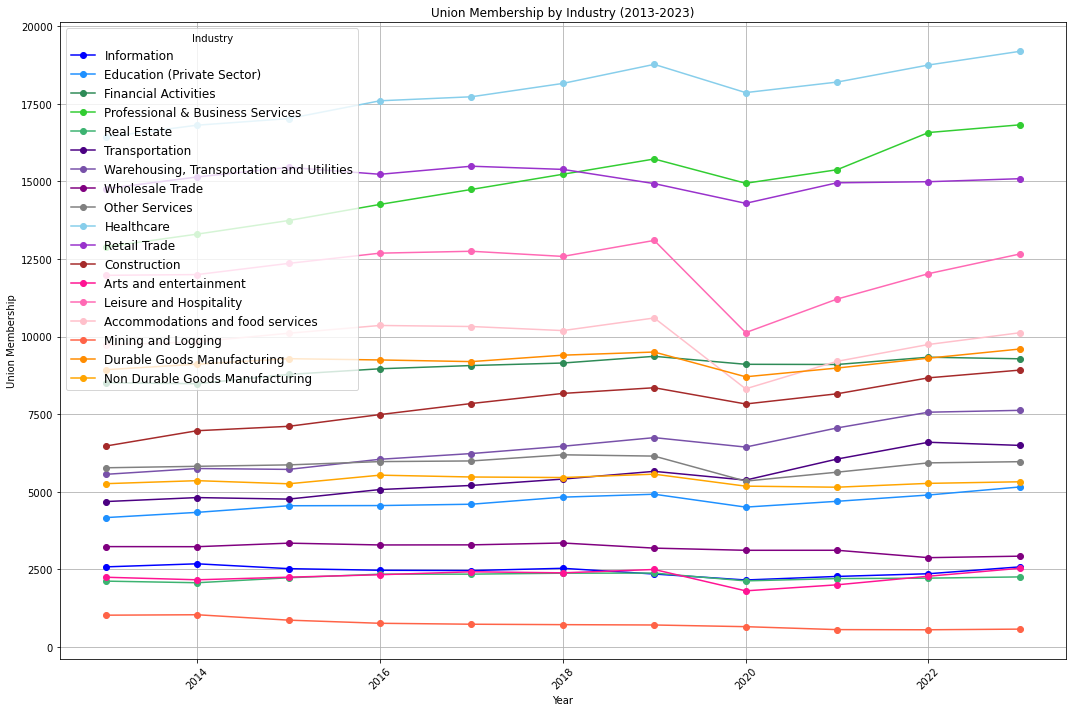

In [80]:
# Plotting union membership over time, only had anual data, 
# imputed for monthly level by taking the mean of each year
grouped_df3 = df.groupby(['industry', 'year', 'month'])['u'].mean().reset_index()

# Recreate the pivot table
pivot_df3 = grouped_df3.pivot_table(index=['year'], columns='industry', values='u')

ordered_columns3 = sorted(pivot_df3.columns, key=lambda x: color_mapping.get(x, '#000000'))
pivot_df3 = pivot_df3[ordered_columns1]

pivot_df3.plot(figsize=(15, 10), marker='o', color= color_mapping)
plt.title('Union Membership by Industry (2013-2023)')
plt.xlabel('Year')
plt.ylabel('Union Membership')
plt.legend(title='Industry', bbox_to_anchor=(0, 1), loc='upper left', prop={'size': 12})
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


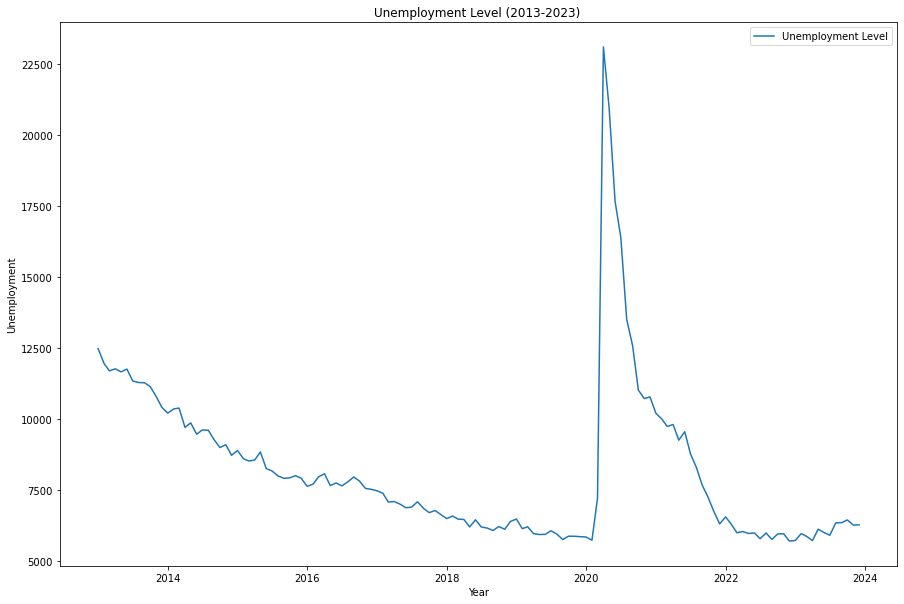

In [81]:
# Plotting unemployment level over time
plt.figure(figsize=(15, 10))

# Sort the DataFrame by the date column
df_sorted = df.sort_values('date')

# Plotting the sorted data

plt.plot(df_sorted['date'], df_sorted['unemployment'], label='Unemployment Level')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Unemployment')
plt.title('Unemployment Level (2013-2023) ')
plt.legend()

plt.show()

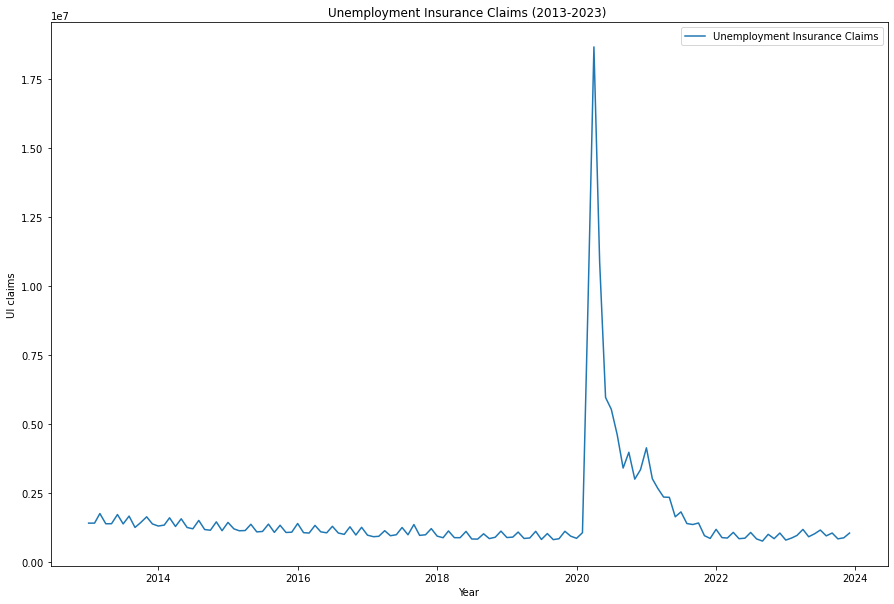

In [82]:
# Plotting unemployment insurance claims over time
plt.figure(figsize=(15, 10))

# Sort the DataFrame by the date column
df_sorted = df.sort_values('date')

# Plotting the sorted data

plt.plot(df_sorted['date'], df_sorted['total_ui_claims'], label='Unemployment Insurance Claims')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('UI claims')
plt.title('Unemployment Insurance Claims (2013-2023) ')
plt.legend()

plt.show()


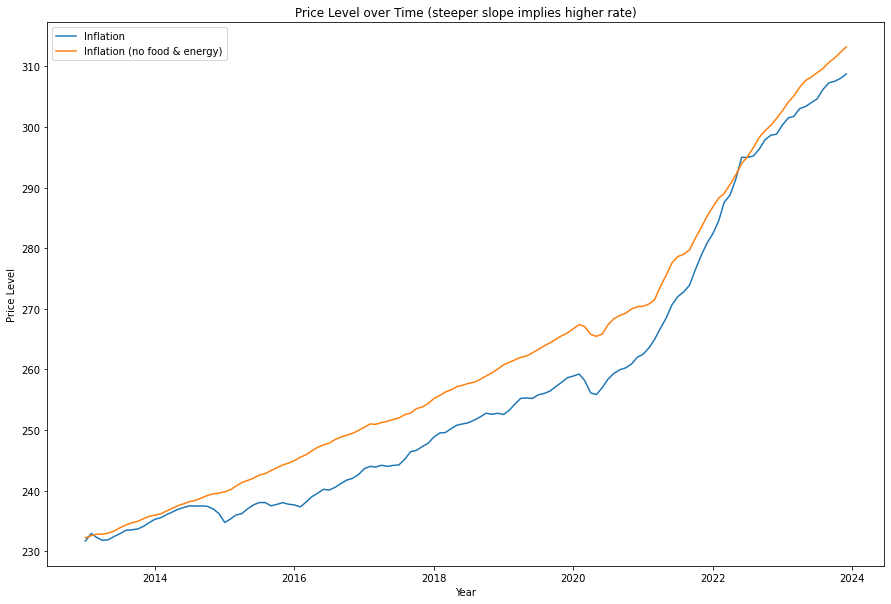

In [83]:
# Plotting inflation levels over time 
plt.figure(figsize=(15, 10))

df_sorted = df.sort_values('date')

# Plotting the sorted data
plt.plot(df_sorted['date'], df_sorted['inflation'], label='Inflation')
plt.plot(df_sorted['date'], df_sorted['inflation_no_f_e'], label='Inflation (no food & energy)')

# Adding labels and title
plt.xlabel('Year')
plt.ylabel('Price Level')
plt.title('Price Level over Time (steeper slope implies higher rate)')
plt.legend()

plt.show()


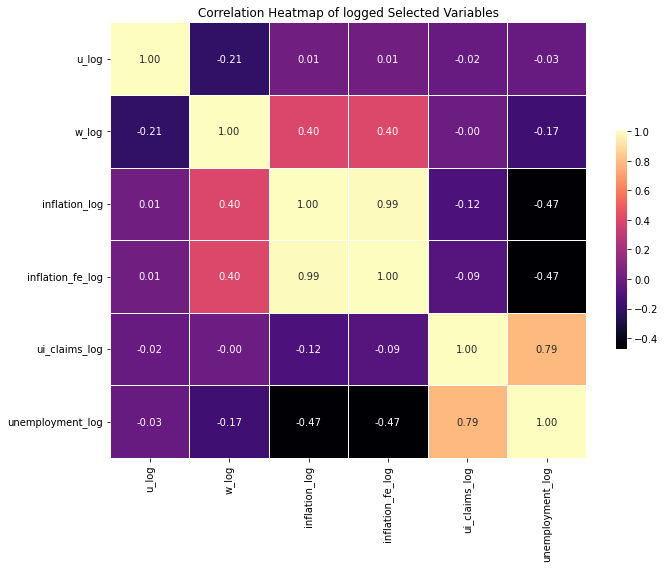

In [84]:
# Creating correlation matrix
cols_of_interest = [ 'u_log', 'w_log', 'inflation_log', 'inflation_fe_log', 'ui_claims_log', 'unemployment_log']
df_selected = df[cols_of_interest]

# Calculate the correlation matrix
corr_matrix = df_selected.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", linewidths=.5, cbar_kws={"shrink": .5})

# Adding title and adjusting layout
plt.title('Correlation Heatmap of logged Selected Variables')
plt.tight_layout()

# Display the heatmap
plt.show()

In [85]:
# Run VIF test for more multicolinearity issues 
X = df[[ 'inflation', 'unemployment', 'u_log', 'w_log']]
X = add_constant(X)  # Adds a constant term to the predictor set

# Drop rows with any NaN values only for the VIF calculation
X_dropna = X.dropna()

# Calculate VIF for each predictor using the temporary DataFrame without NaNs
vif = pd.DataFrame()
vif["variables"] = X_dropna.columns
vif["VIF"] = [variance_inflation_factor(X_dropna.values, i) for i in range(X_dropna.shape[1])]

print(vif)



      variables         VIF
0         const  375.800050
1     inflation    1.353091
2  unemployment    1.147907
3         u_log    1.060621
4         w_log    1.256874


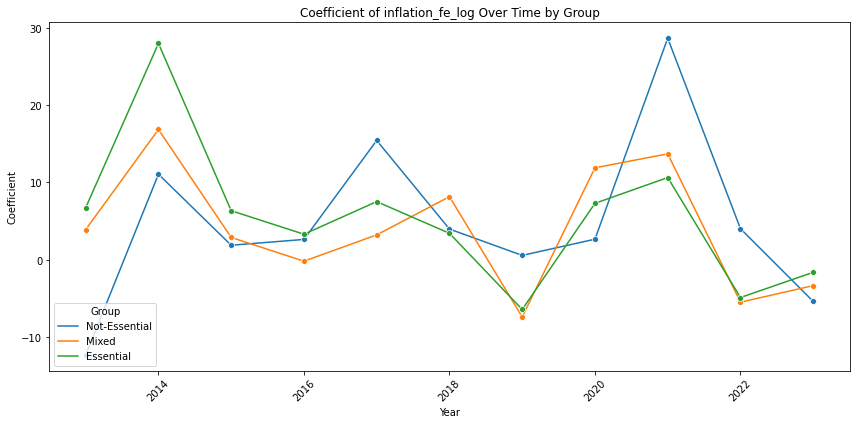

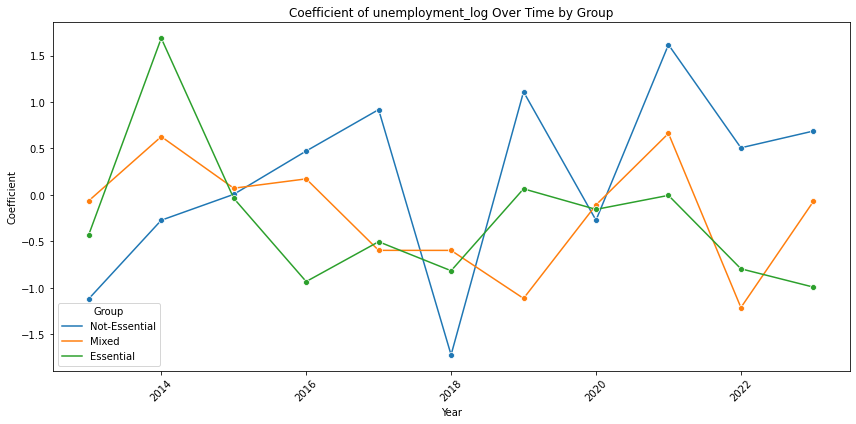

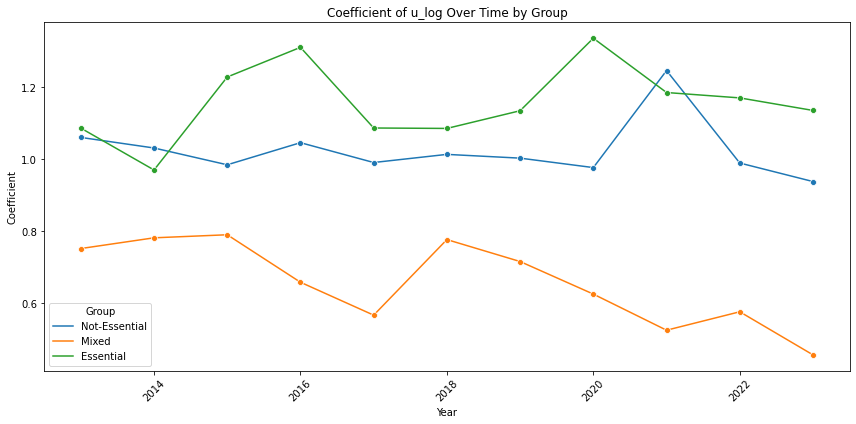

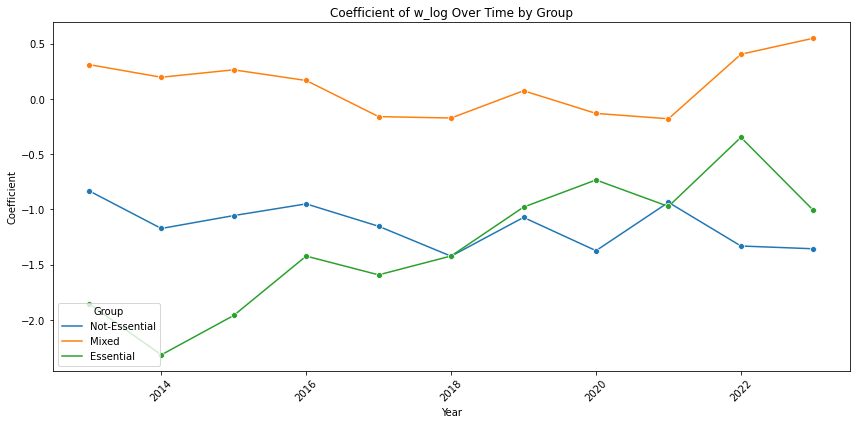

In [86]:
# plotting the effect of each variable on job openings over time for each group 
variables_to_plot = ['inflation_fe_log', 'unemployment_log', 'u_log', 'w_log']
# Plotting each category for each variable
for variable_to_plot in variables_to_plot:
    coefficients_df_filtered = coefficients_df[coefficients_df['variable'] == variable_to_plot]

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=coefficients_df_filtered, x='year', y='coefficient', hue='group', marker='o', linestyle='-')
    plt.title(f'Coefficient of {variable_to_plot} Over Time by Group')
    plt.xlabel('Year')
    plt.ylabel('Coefficient')
    plt.xticks(rotation=45)
    plt.legend(title='Group', loc='lower left')
    plt.tight_layout()
    plt.show()

In [87]:
print(model_summaries)


{'Total Private': <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                 jo_log   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     392.4
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.34e-85
Time:                        15:45:28   Log-Likelihood:                 128.52
No. Observations:                 132   AIC:                            -237.0
Df Residuals:                     122   BIC:                            -208.2
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------

In [88]:
print(results_summaries)

{('Not-Essential', 2013): <class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                 jo_log   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     207.0
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           6.94e-22
Time:                        15:45:28   Log-Likelihood:                 13.077
No. Observations:                  36   AIC:                            -16.15
Df Residuals:                      31   BIC:                            -8.237
Df Model:                           4                                         
Covariance Type:                  HC1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------

In [89]:
# Regressing covid and unemployment on union membership
# Iterate through each industry and run separate regressions
for industry in df['industry'].unique():
    df_industry = df[df['industry'] == industry].copy()
    formula = ('u_log ~ C(covid) * unemployment_log')
    # Fit the model with robust standard errors
    model = smf.ols(formula, data=df_industry).fit(cov_type='HC1')

    # Print the summary for each industry's model
    print(f"Industry: {industry}")
    print(model.summary())
    print("\n\n")


Industry: Total Private
                            OLS Regression Results                            
Dep. Variable:                  u_log   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     607.8
Date:                Thu, 21 Mar 2024   Prob (F-statistic):           1.67e-75
Time:                        15:45:33   Log-Likelihood:                 355.74
No. Observations:                 132   AIC:                            -703.5
Df Residuals:                     128   BIC:                            -692.0
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------